# AddRNN

# Train-Test 7:3

## Crude Oil - 7:3

Epoch 1/20
29/29 [==============================] - 1s 4ms/step - loss: 0.2368
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 5/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 7/20
29/29 [==============================] - 0s 4ms/step - loss: 9.0926e-04
Epoch 8/20
29/29 [==============================] - 0s 3ms/step - loss: 9.1858e-04
Epoch 9/20
29/29 [==============================] - 0s 3ms/step - loss: 7.4268e-04
Epoch 10/20
29/29 [==============================] - 0s 4ms/step - loss: 6.8492e-04
Epoch 11/20
29/29 [==============================] - 0s 3ms/step - loss: 6.3839e-04
Epoch 12/20
29/29 [==============================] - 0s 3ms/step - loss: 7.2540e-04
Epoch 13/20
29/29 [======

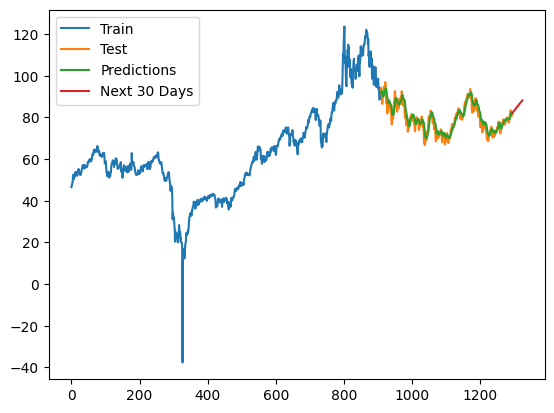

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


## Gasoline RBOB - 7:3

Epoch 1/20
29/29 [==============================] - 1s 4ms/step - loss: 0.0246
Epoch 2/20
29/29 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 3/20
29/29 [==============================] - 0s 6ms/step - loss: 5.5483e-04
Epoch 4/20
29/29 [==============================] - 0s 5ms/step - loss: 4.1271e-04
Epoch 5/20
29/29 [==============================] - 0s 6ms/step - loss: 3.9999e-04
Epoch 6/20
29/29 [==============================] - 0s 6ms/step - loss: 4.0889e-04
Epoch 7/20
29/29 [==============================] - 0s 5ms/step - loss: 4.0401e-04
Epoch 8/20
29/29 [==============================] - 0s 5ms/step - loss: 4.1103e-04
Epoch 9/20
29/29 [==============================] - 0s 5ms/step - loss: 4.0702e-04
Epoch 10/20
29/29 [==============================] - 0s 5ms/step - loss: 3.9876e-04
Epoch 11/20
29/29 [==============================] - 0s 5ms/step - loss: 3.8314e-04
Epoch 12/20
29/29 [==============================] - 0s 9ms/step - loss: 4.0084e-04
Epoch 13/

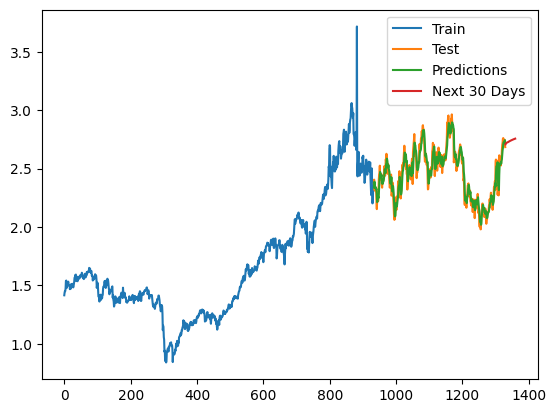

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


## Heating Oil - 7:3

Epoch 1/20
29/29 [==============================] - 1s 3ms/step - loss: 0.0505
Epoch 2/20
29/29 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 4.7873e-04
Epoch 4/20
29/29 [==============================] - 0s 4ms/step - loss: 4.2556e-04
Epoch 5/20
29/29 [==============================] - 0s 4ms/step - loss: 4.4083e-04
Epoch 6/20
29/29 [==============================] - 0s 4ms/step - loss: 4.4114e-04
Epoch 7/20
29/29 [==============================] - 0s 4ms/step - loss: 3.9427e-04
Epoch 8/20
29/29 [==============================] - 0s 4ms/step - loss: 3.9103e-04
Epoch 9/20
29/29 [==============================] - 0s 3ms/step - loss: 3.8520e-04
Epoch 10/20
29/29 [==============================] - 0s 4ms/step - loss: 3.9015e-04
Epoch 11/20
29/29 [==============================] - 0s 4ms/step - loss: 3.7075e-04
Epoch 12/20
29/29 [==============================] - 0s 4ms/step - loss: 3.8185e-04
Epoch 13/

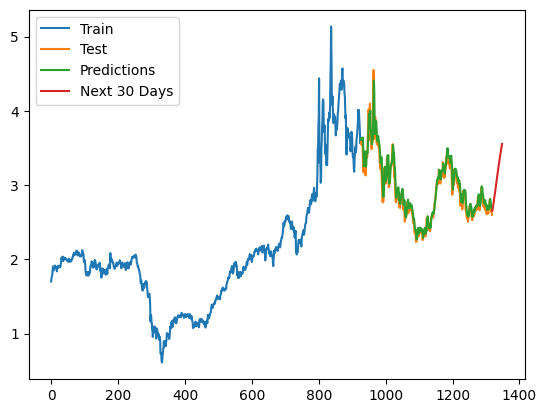

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


# Train-Test 8:2

## Crude Oil - 8:2

Epoch 1/20
33/33 [==============================] - 1s 3ms/step - loss: 0.1038
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 3/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 9.1054e-04
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 8.4681e-04
Epoch 6/20
33/33 [==============================] - 0s 3ms/step - loss: 7.7520e-04
Epoch 7/20
33/33 [==============================] - 0s 3ms/step - loss: 7.2605e-04
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 5.2726e-04
Epoch 9/20
33/33 [==============================] - 0s 3ms/step - loss: 4.1627e-04
Epoch 10/20
33/33 [==============================] - 0s 4ms/step - loss: 3.7429e-04
Epoch 11/20
33/33 [==============================] - 0s 4ms/step - loss: 3.9539e-04
Epoch 12/20
33/33 [==============================] - 0s 3ms/step - loss: 3.8634e-04
Epoch 13/20
3

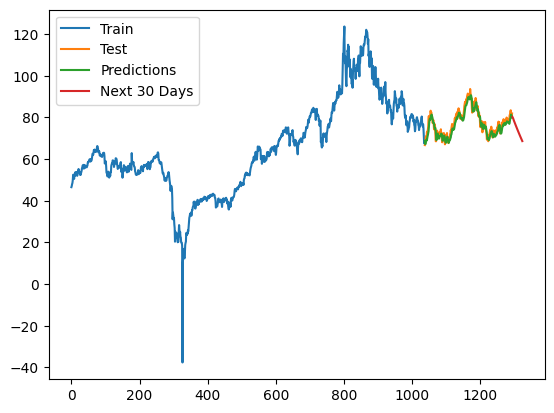

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


## Gasoline RBOB - 8:2

Epoch 1/20
33/33 [==============================] - 1s 3ms/step - loss: 0.0892
Epoch 2/20
33/33 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 3/20
33/33 [==============================] - 0s 3ms/step - loss: 4.7441e-04
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 4.5224e-04
Epoch 5/20
33/33 [==============================] - 0s 3ms/step - loss: 4.3452e-04
Epoch 6/20
33/33 [==============================] - 0s 3ms/step - loss: 4.2489e-04
Epoch 7/20
33/33 [==============================] - 0s 3ms/step - loss: 4.3331e-04
Epoch 8/20
33/33 [==============================] - 0s 3ms/step - loss: 4.1788e-04
Epoch 9/20
33/33 [==============================] - 0s 3ms/step - loss: 4.2798e-04
Epoch 10/20
33/33 [==============================] - 0s 4ms/step - loss: 4.0835e-04
Epoch 11/20
33/33 [==============================] - 0s 3ms/step - loss: 4.0965e-04
Epoch 12/20
33/33 [==============================] - 0s 3ms/step - loss: 4.1686e-04
Epoch 13/

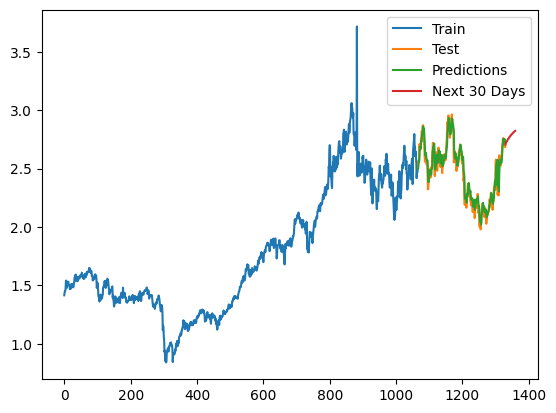

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()

## Heating Oil - 8:2

Epoch 1/20
33/33 [==============================] - 2s 4ms/step - loss: 0.0278
Epoch 2/20
33/33 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 3/20
33/33 [==============================] - 0s 3ms/step - loss: 7.3279e-04
Epoch 4/20
33/33 [==============================] - 0s 3ms/step - loss: 6.6302e-04
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 6.3736e-04
Epoch 6/20
33/33 [==============================] - 0s 4ms/step - loss: 6.0781e-04
Epoch 7/20
33/33 [==============================] - 0s 4ms/step - loss: 6.0416e-04
Epoch 8/20
33/33 [==============================] - 0s 4ms/step - loss: 6.3883e-04
Epoch 9/20
33/33 [==============================] - 0s 4ms/step - loss: 5.7050e-04
Epoch 10/20
33/33 [==============================] - 0s 4ms/step - loss: 5.3513e-04
Epoch 11/20
33/33 [==============================] - 0s 3ms/step - loss: 5.2998e-04
Epoch 12/20
33/33 [==============================] - 0s 4ms/step - loss: 5.4400e-04
Epoch 13/

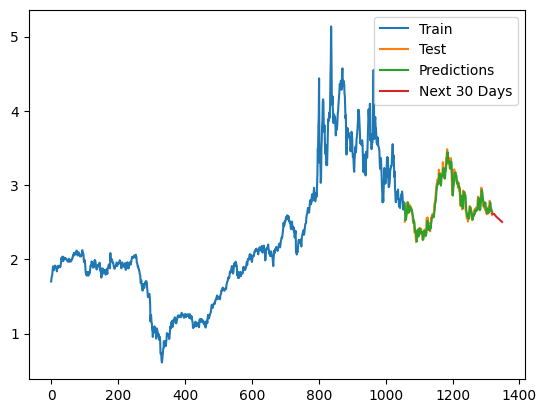

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()

# Train-Test 9:1

## Crude Oil - 9:1

Epoch 1/20
37/37 [==============================] - 1s 4ms/step - loss: 0.0704
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 6.7446e-04
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 5.9793e-04
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 5.0018e-04
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 4.3237e-04
Epoch 7/20
37/37 [==============================] - 0s 4ms/step - loss: 3.9083e-04
Epoch 8/20
37/37 [==============================] - 0s 4ms/step - loss: 3.9152e-04
Epoch 9/20
37/37 [==============================] - 0s 4ms/step - loss: 4.2569e-04
Epoch 10/20
37/37 [==============================] - 0s 4ms/step - loss: 3.8486e-04
Epoch 11/20
37/37 [==============================] - 0s 3ms/step - loss: 3.7512e-04
Epoch 12/20
37/37 [==============================] - 0s 4ms/step - loss: 4.0638e-04
Epoch 13/

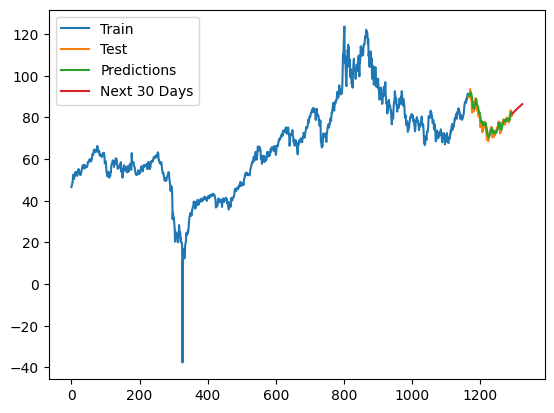

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


## Gasoline RBOB - 9:1

Epoch 1/20
38/38 [==============================] - 1s 3ms/step - loss: 0.0121
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 9.1969e-04
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 5.6492e-04
Epoch 4/20
38/38 [==============================] - 0s 3ms/step - loss: 5.6166e-04
Epoch 5/20
38/38 [==============================] - 0s 3ms/step - loss: 5.2325e-04
Epoch 6/20
38/38 [==============================] - 0s 3ms/step - loss: 5.4041e-04
Epoch 7/20
38/38 [==============================] - 0s 3ms/step - loss: 5.1643e-04
Epoch 8/20
38/38 [==============================] - 0s 3ms/step - loss: 5.4239e-04
Epoch 9/20
38/38 [==============================] - 0s 3ms/step - loss: 4.9592e-04
Epoch 10/20
38/38 [==============================] - 0s 4ms/step - loss: 4.8606e-04
Epoch 11/20
38/38 [==============================] - 0s 4ms/step - loss: 4.9767e-04
Epoch 12/20
38/38 [==============================] - 0s 4ms/step - loss: 5.4621e-04
Epoch

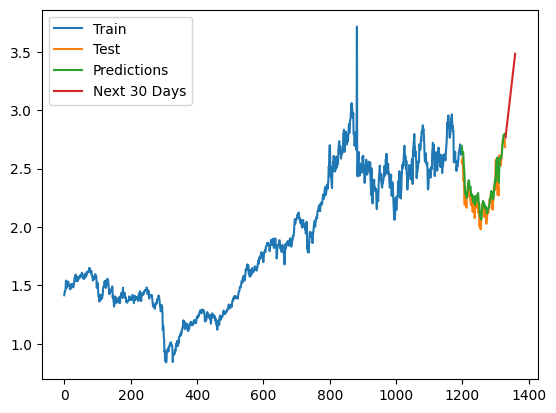

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()


## Heating Oil - 9:1

Epoch 1/20
37/37 [==============================] - 1s 3ms/step - loss: 0.0237
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: 9.6040e-04
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 4.6072e-04
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 4.1793e-04
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 3.7594e-04
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 4.0866e-04
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 3.7140e-04
Epoch 8/20
37/37 [==============================] - 0s 3ms/step - loss: 4.1152e-04
Epoch 9/20
37/37 [==============================] - 0s 4ms/step - loss: 3.5690e-04
Epoch 10/20
37/37 [==============================] - 0s 4ms/step - loss: 3.6298e-04
Epoch 11/20
37/37 [==============================] - 0s 5ms/step - loss: 3.5545e-04
Epoch 12/20
37/37 [==============================] - 0s 6ms/step - loss: 3.6006e-04
Epoch

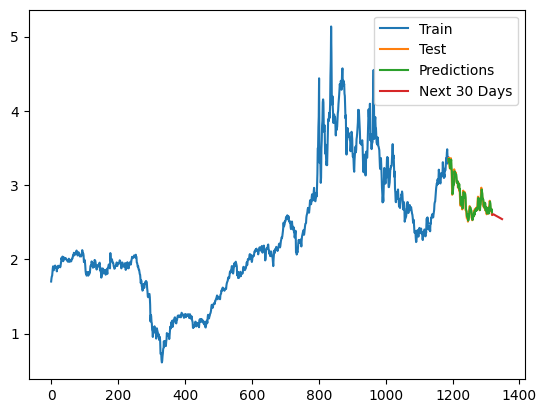

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.strftime('%d-%m-%Y')
df = df.iloc[::-1].reset_index(drop=True)
df
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next 30 days
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)
forecast = []
for _ in range(30):
    next_pred = model.predict(last_seq)
    forecast.append(next_pred[0, 0])
    last_seq = np.roll(last_seq, -1)
    last_seq[0, -1, 0] = next_pred[0, 0]

forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape)

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)
plt.plot(range(len(df), len(df) + 30), forecast_inverse)
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days'])
plt.show()
